## tracking the detected pupil



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Using 42 frames recorded with 2015-11-05 notebook


In [2]:
import cv2
import os

N_frame = 42

folder = '/tmp/debug'
H, W, three = cv2.imread(os.path.join(folder, 'frame_1.png')).shape

movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)

for i in range(N_frame):
    fname = 'frame_{i}.png'.format(i=i)
    movie[:, :, :, i] = cv2.cvtColor(cv2.imread(os.path.join(folder, fname)), cv2.COLOR_BGR2RGB)


(720, 1280, 3, 42) 0 255


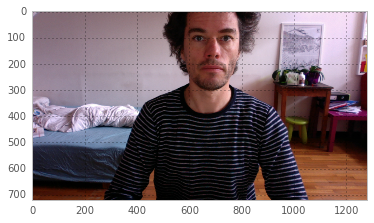

In [3]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(movie[:, :, :, 0])

## Simplifying the whole process

Even simpler : no need to extract eye position and do only detect within the (half) face:

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


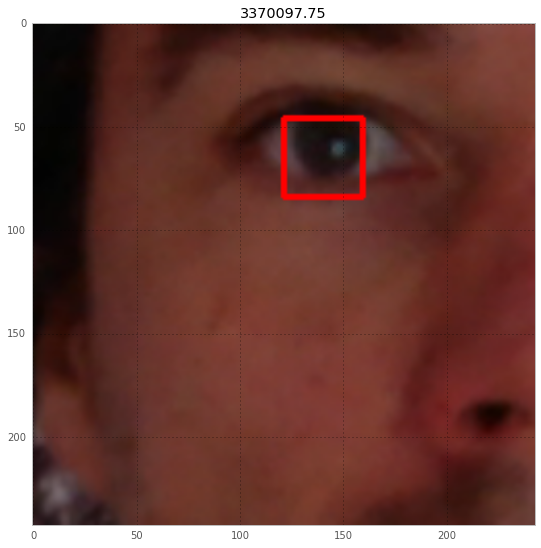

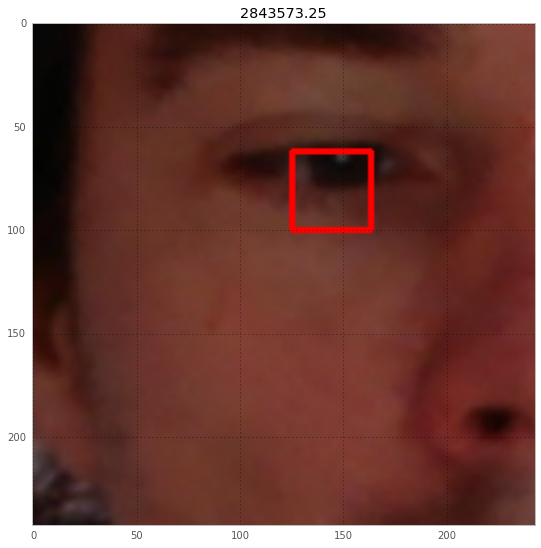

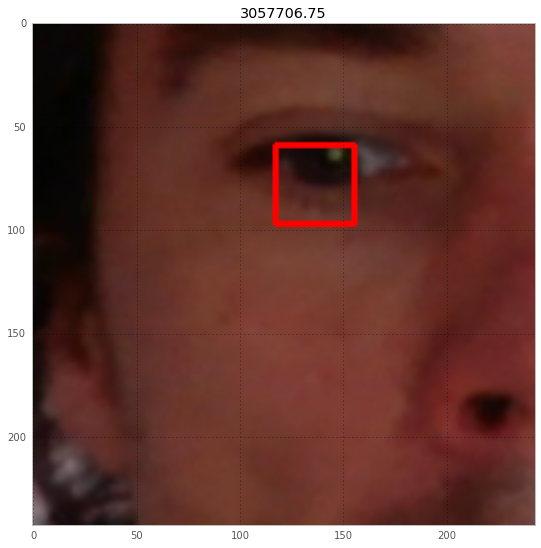

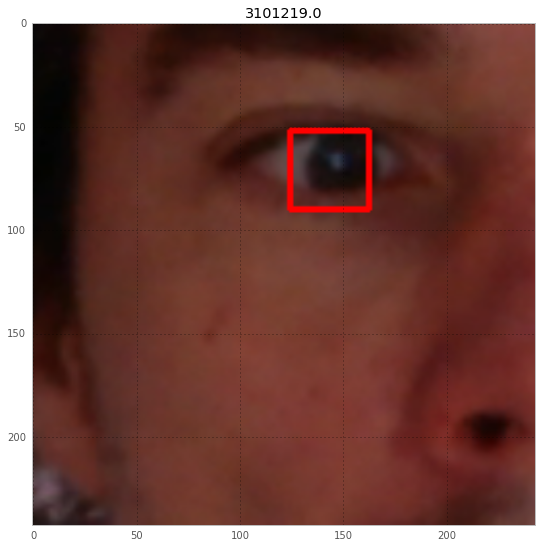

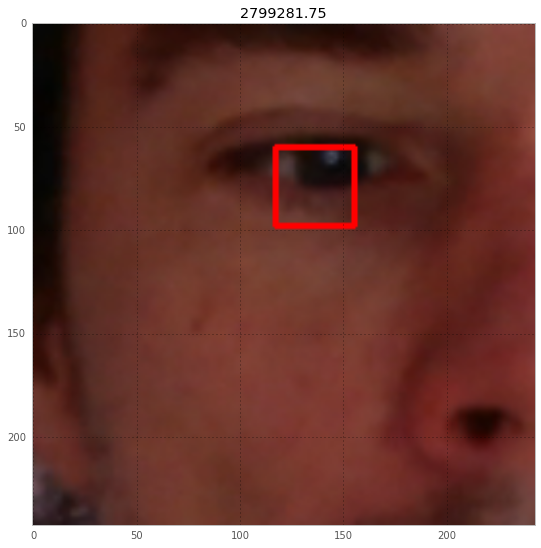

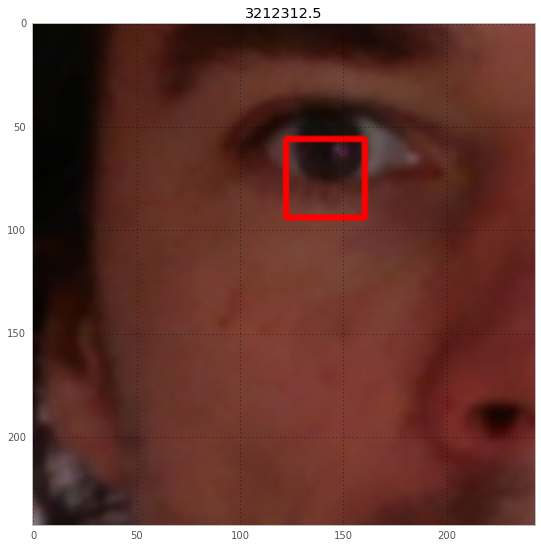

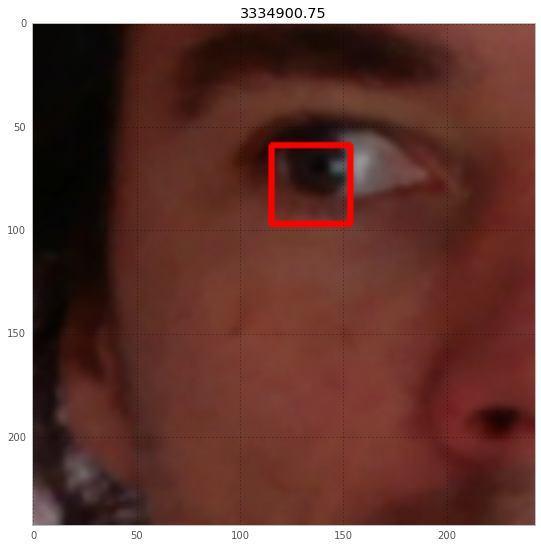

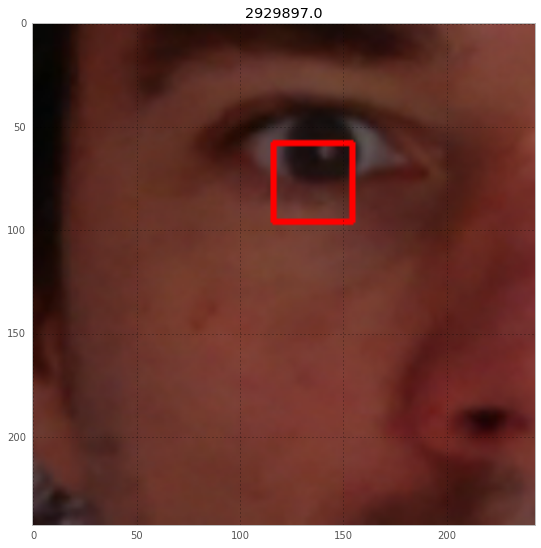

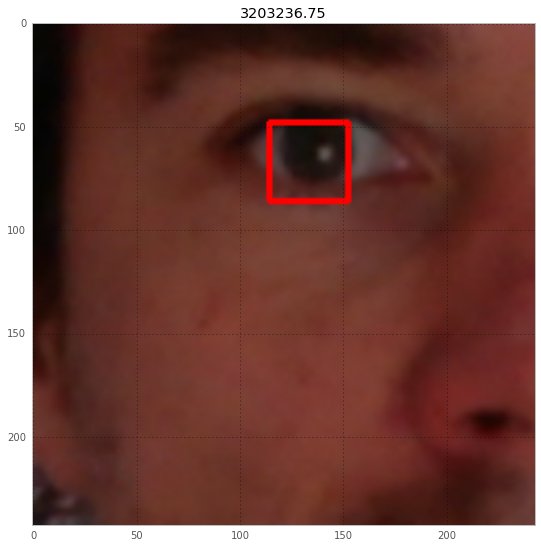

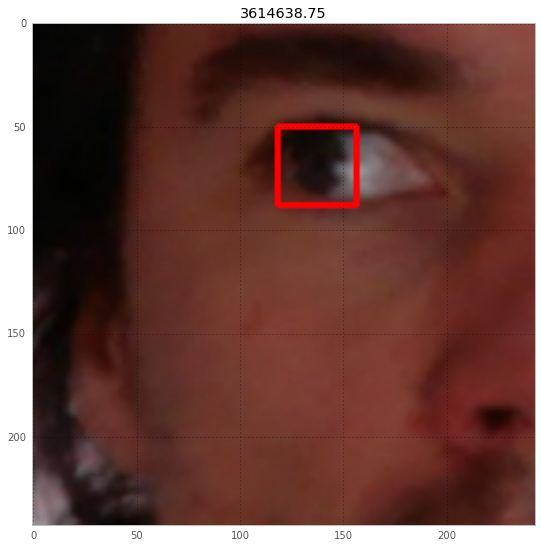

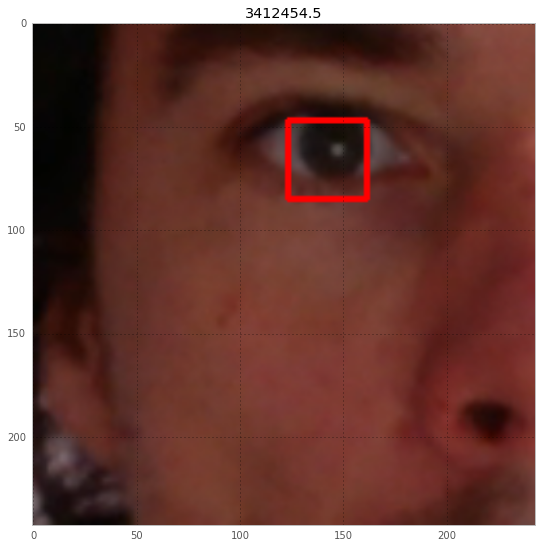

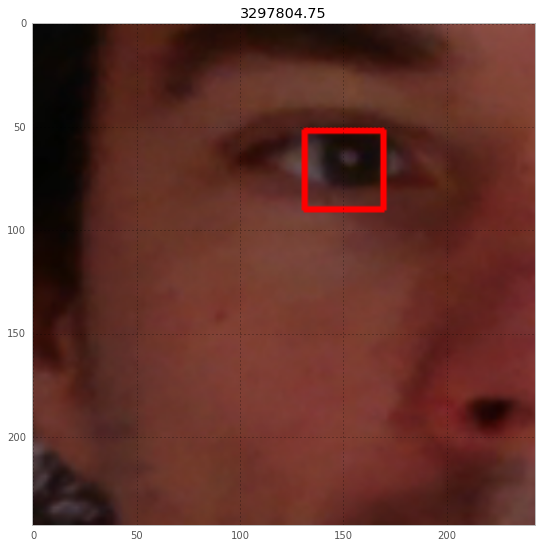

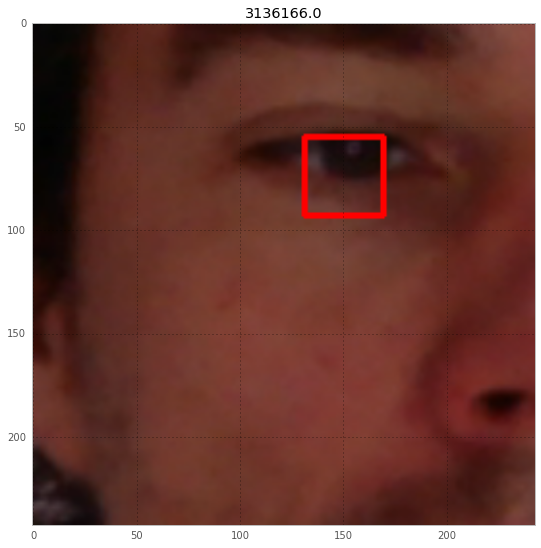

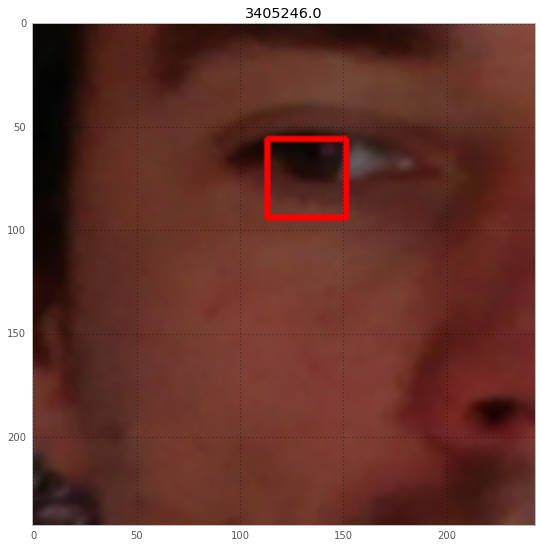

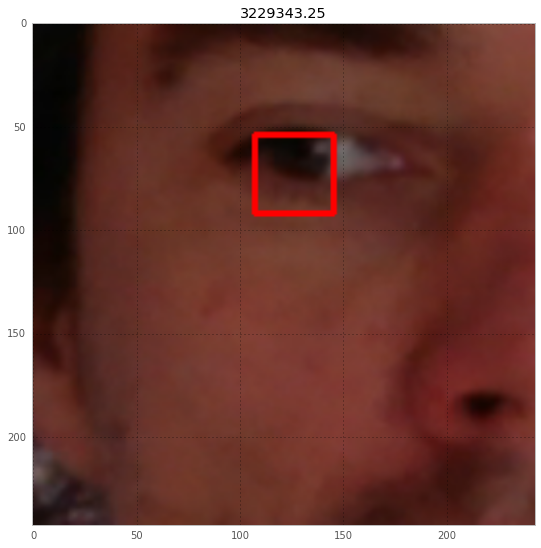

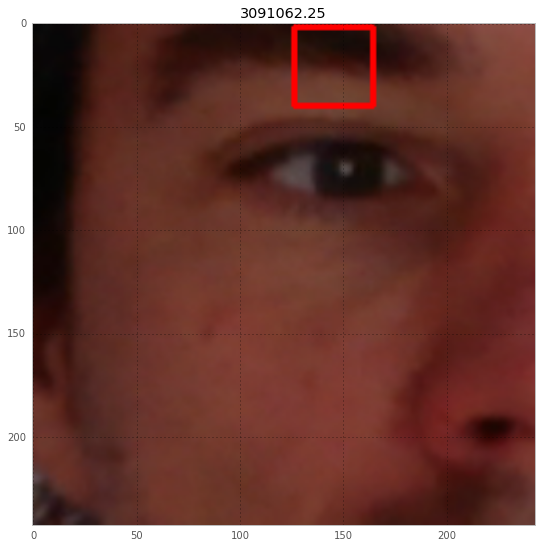

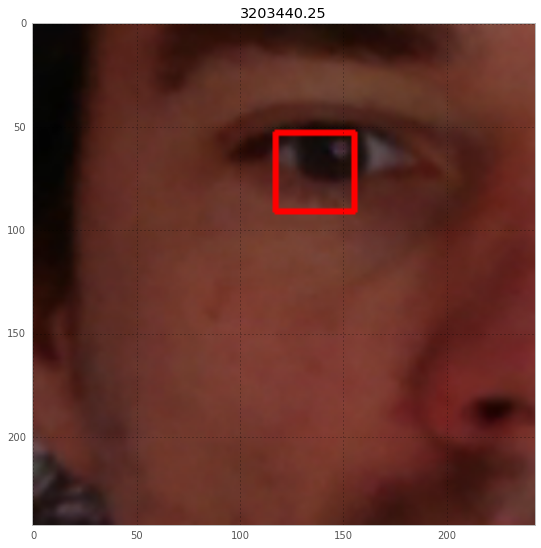

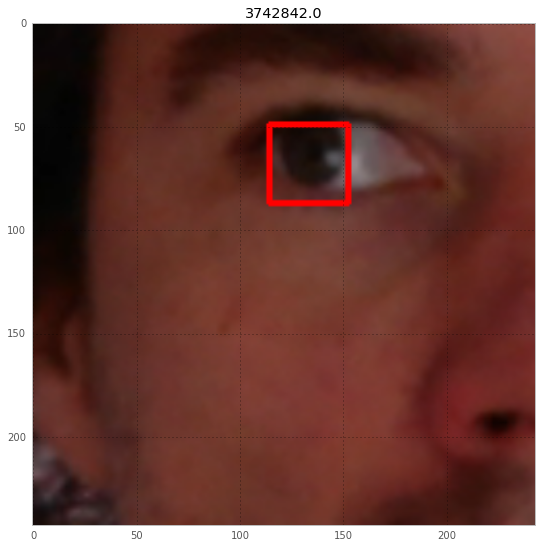

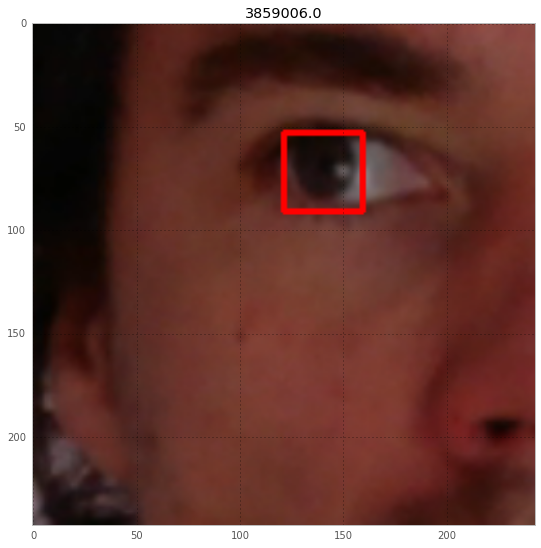

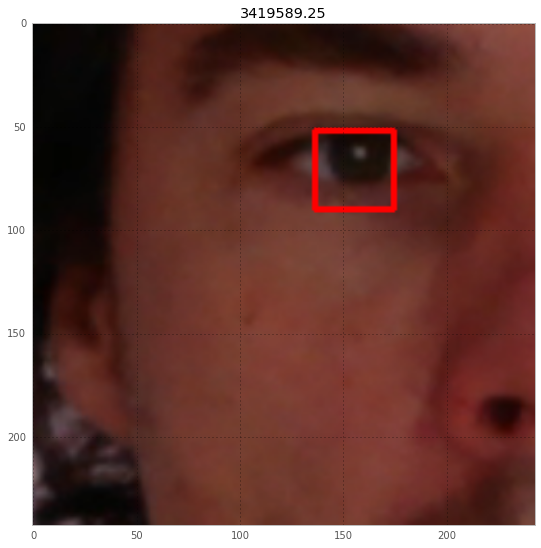

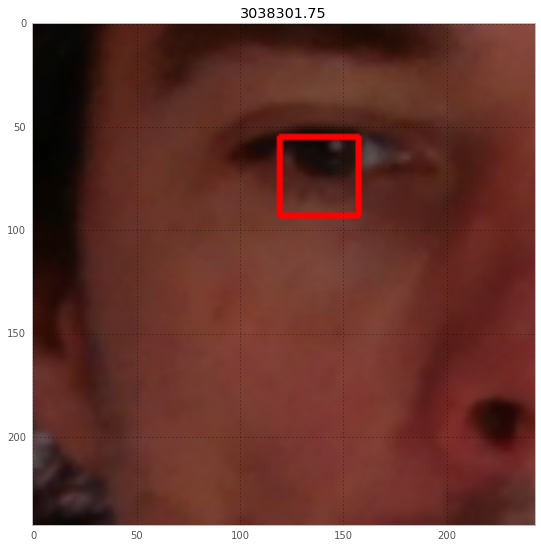

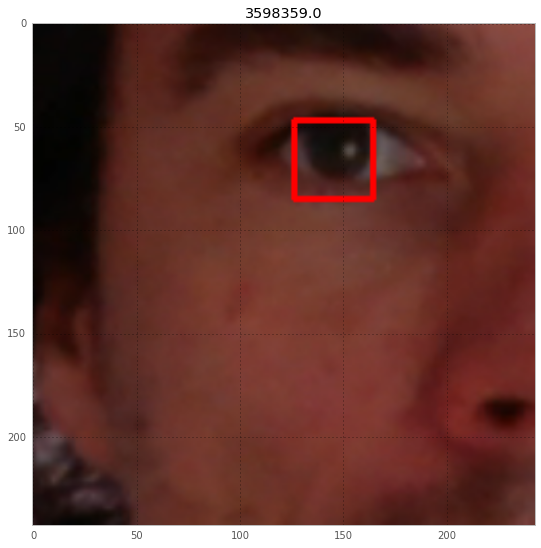

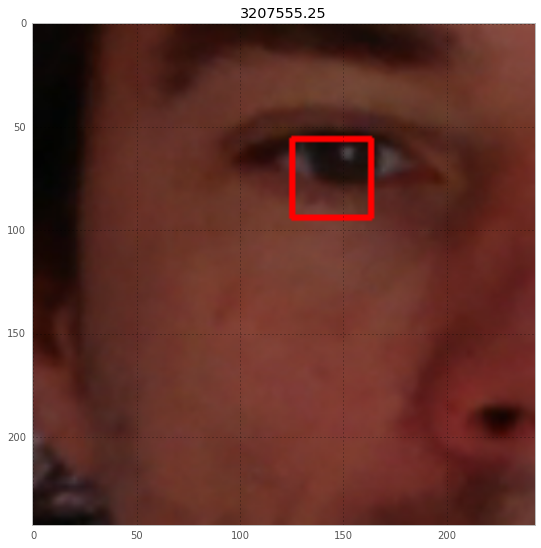

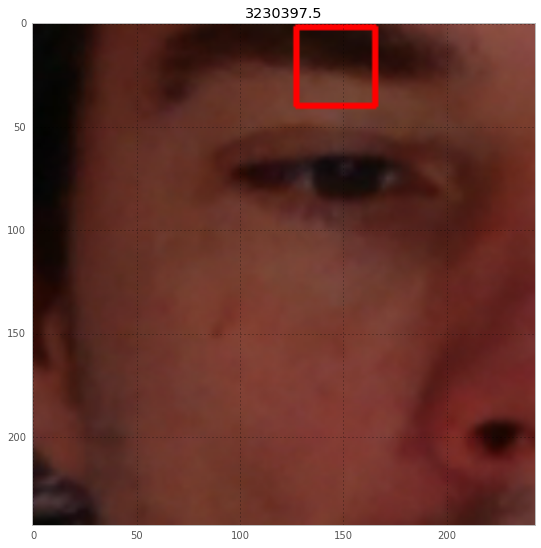

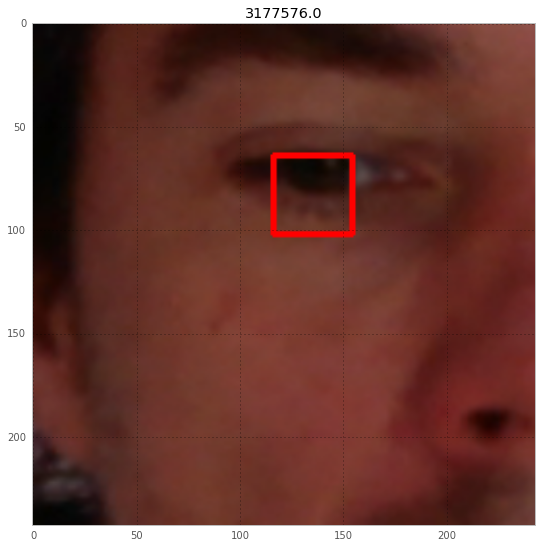

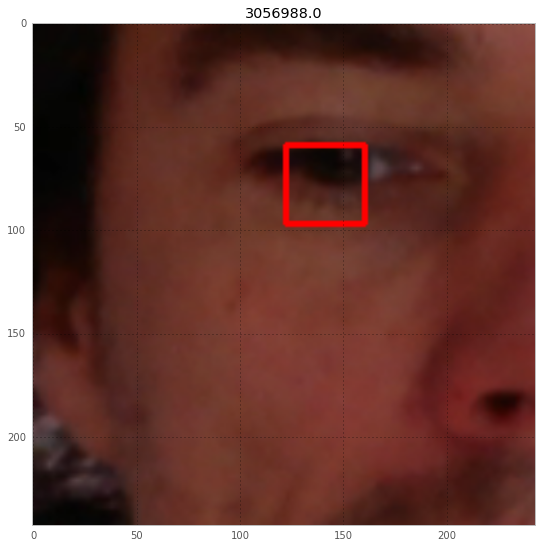

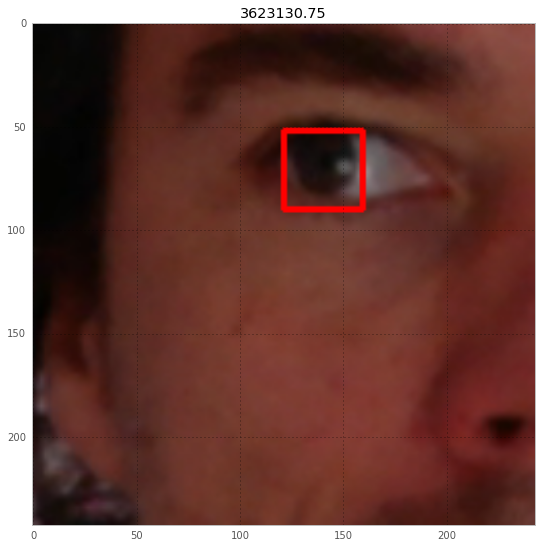

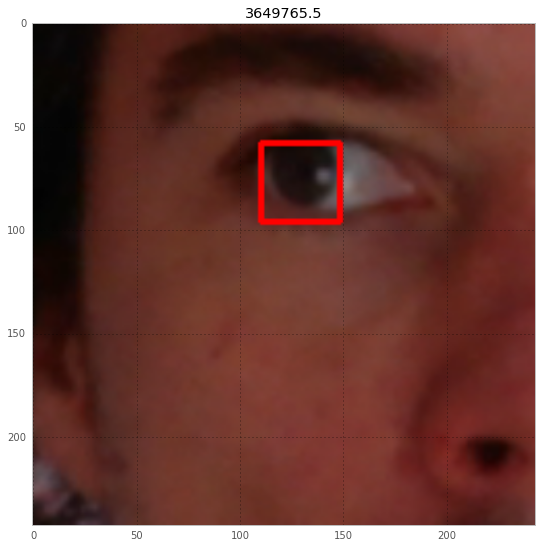

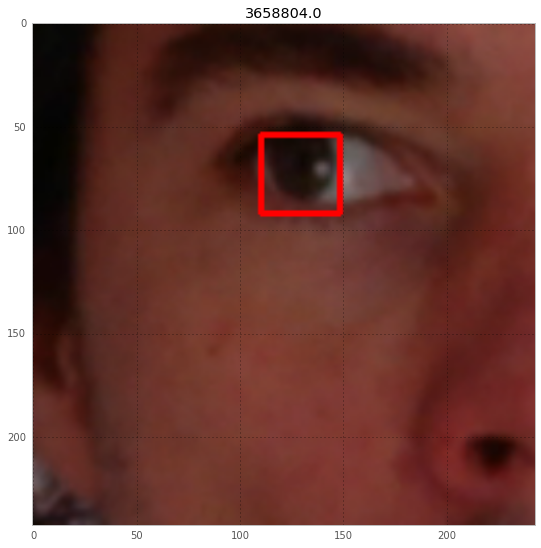

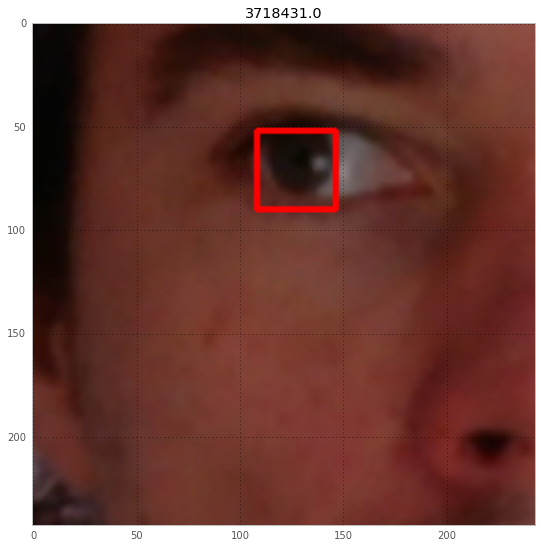

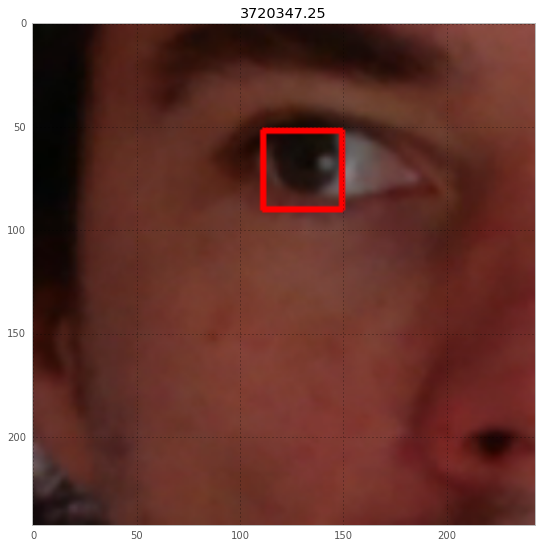

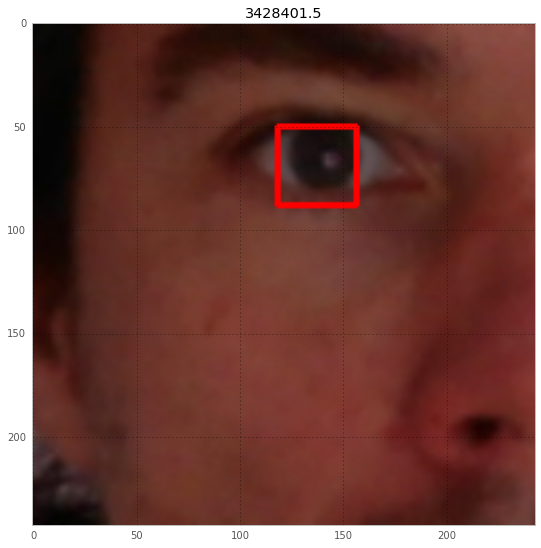

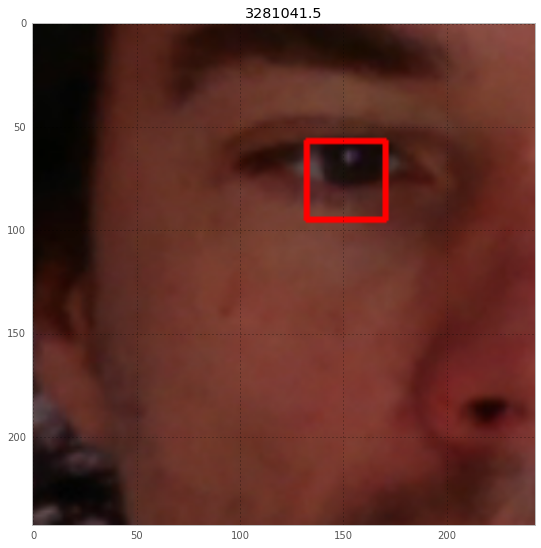

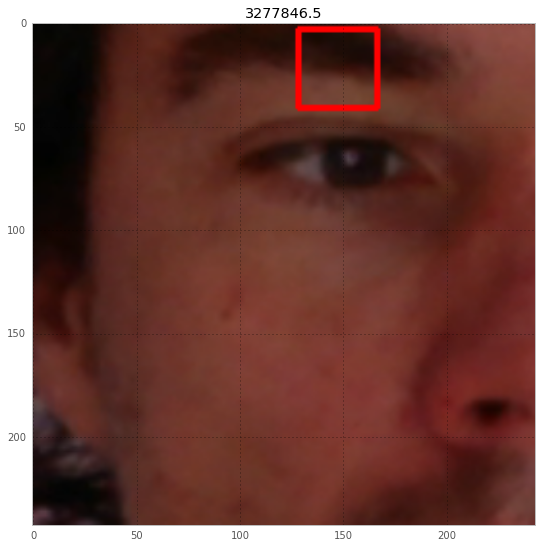

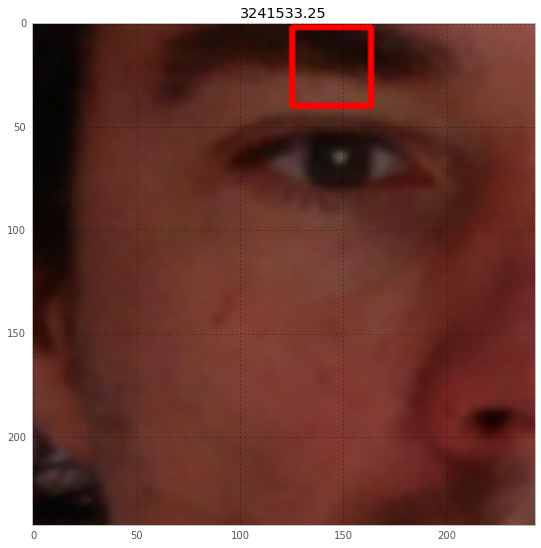

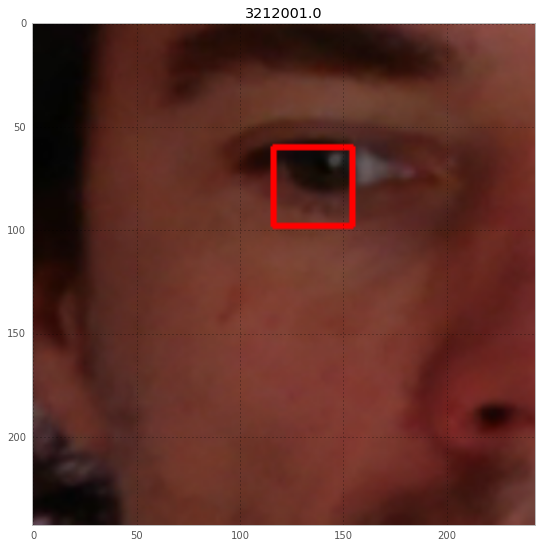

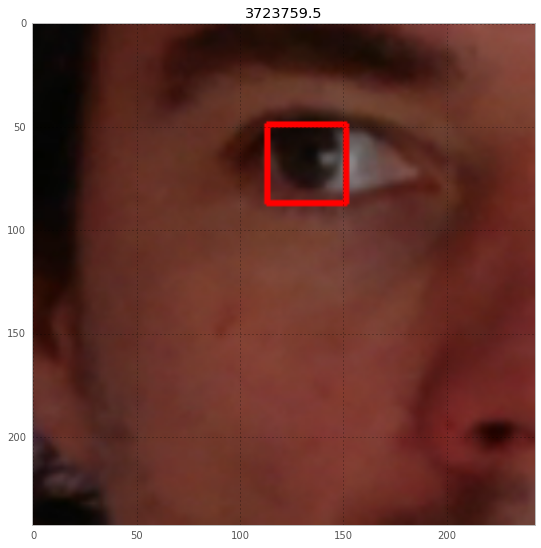

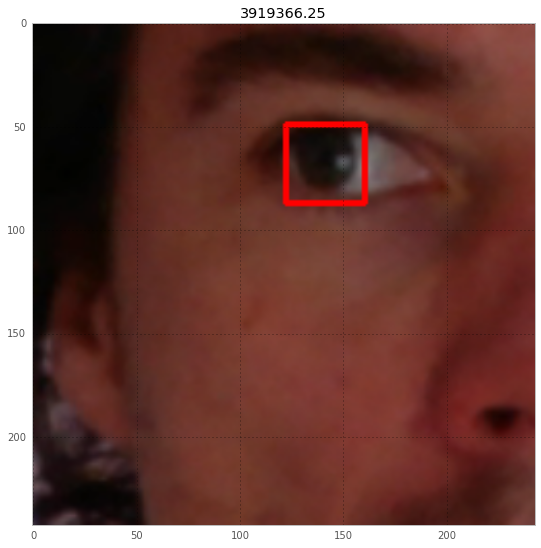

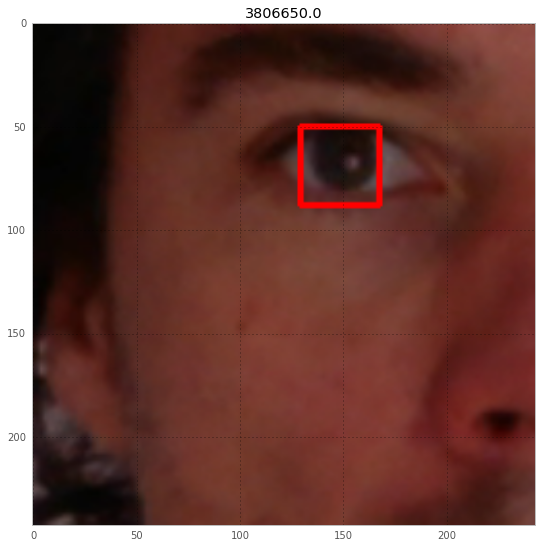

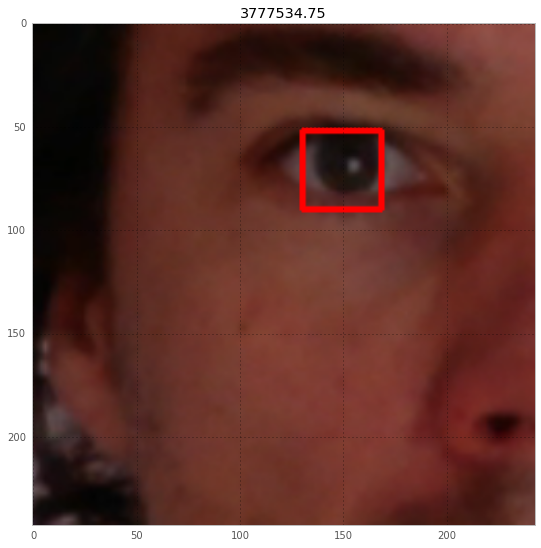

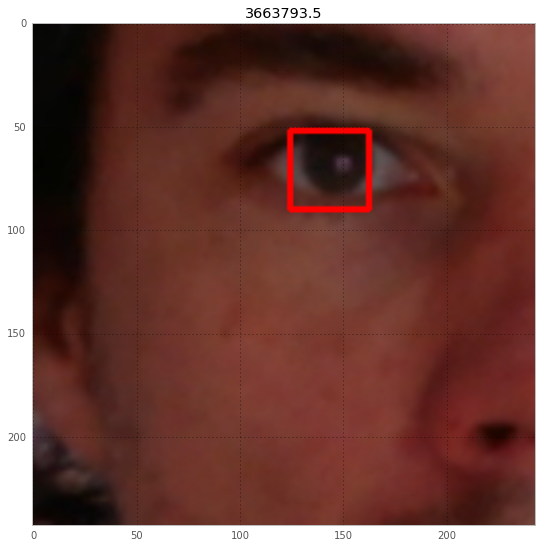

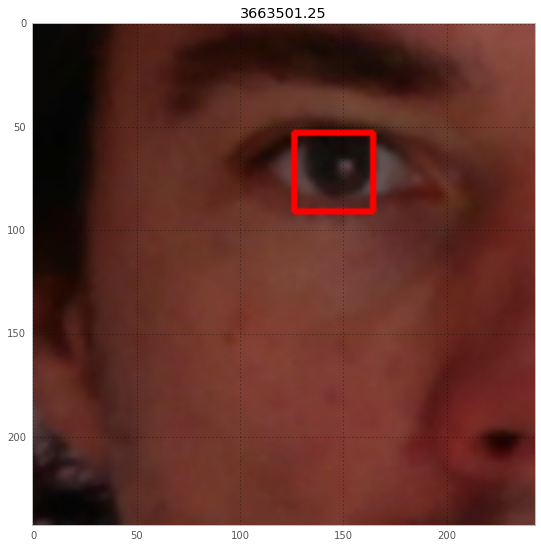

In [4]:
from LeCheapEyeTracker import Client, Server
et = Server()
img_ = movie[:, :, :, 0].copy()


import time
start = time.time()
import cv2
#cam.head_size = 452
face_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
#from LeCheapEyeTracker.constants import face_cascade

#eye_template = cv2.imread('../src/my_eye.png')
from LeCheapEyeTracker.constants import eye_image as eye_template

def get_just_one(image, cascade):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # We set set minNeighbors=1 then increase it until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
    features, minNeighbors = [], 1
    while len(features) == 0 and minNeighbors<20:
        features = cascade.detectMultiScale(image, 1.1, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
        minNeighbors += 1
        #print(minNeighbors)
    return features[0], minNeighbors


template = eye_template.copy()
wt, ht = template.shape[1], template.shape[0]
for i_t in range(N_frame):
    img_ = movie[:, :, :, i_t].copy()
    (x, y, w, h), minNeighbors = get_just_one(img_, face_cascade)
    #print(w, h)
    #img_face = img_[y:y+h, x:x+w]
    half_w, quarter_w = w//2, w//4
    img_face = img_[(y+quarter_w):(y+quarter_w+half_w), x:x+half_w]
    img_face = cv2.resize(img_face, (et.head_size//2, et.head_size//2))

    res = cv2.matchTemplate(img_face, template, cv2.TM_CCOEFF)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    #print(min_val, max_val, min_loc, max_loc)
    bottom_right = (max_loc[0] + wt, max_loc[1] + ht)

    cv2.rectangle(img_face, max_loc, bottom_right, 255, 2)
    fig, axs = plt.subplots(1, 1, figsize=(9, 9))
    axs.imshow(img_face)
    axs.set_title(max_val)


Fair enough!

## Using the package

In [7]:
from LeCheapEyeTracker import Client, Server
et = Server()
img_ = movie[:, :, :, 0].copy()

for i_t in range(N_frame):
    img_ = movie[:, :, :, i_t].copy()

    try:
        img_face, res, t0 = et.process_frame(img_, et.clock())
        bottom_right = (int(res[0] + et.wt/2), int(res[1] + et.ht/2))
        top_left = (int(res[0] - et.wt/2), int(res[1] - et.ht/2))

        cv2.rectangle(img_face, top_left, bottom_right, 255, 2)
        fig, axs = plt.subplots(1, 1, figsize=(9, 9))
        axs.imshow(img_face)
        axs.set_title(res)
    except:
        pass
